In [ ]:
#import dependency
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import requests


In [ ]:
# Create a directory content/sample_data and drop the config file in it
import sys
sys.path.append('/content/sample_data/')
from config import config as config
from config import jdbc_url as jdbc_url

# **Connect to AWS Database using spark**

In [ ]:
import os
# Find the latest version of spark 2.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.0'
spark_version = 'spark-3.0.1'
# spark_version = 'spark-2.4.7'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Fetched 88.7 kB in 2s (42.6 kB/s)
Reading package lists... Done


In [ ]:
# Download the Postgres driver that will allow Spark to interact with Postgres.
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2020-11-11 01:52:50--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.2’

postgresql-42.2.16. 100%[===================>] 979.38K  --.-KB/s    in 0.1s    

2020-11-11 01:52:51 (9.58 MB/s) - ‘postgresql-42.2.16.jar.2’ saved [1002883/1002883]



In [ ]:
from pyspark.sql import SparkSession
#spark = SparkSession.builder.appName("BigData-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()
spark = SparkSession.builder.appName("FinalGroupPrj-Challenge").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [ ]:
# Configure settings for RDS
mode = "read"
jdbc_url= jdbc_url
config = config

In [ ]:
# Connect to our database and create or df for our Train data
pushdown_query = "(select * from house_prices where data_type = 'Train') houses"
df_train= spark.read.jdbc(url=jdbc_url, table=pushdown_query, properties=config)
df_train.show()

+--------+-------------+-----------+-----------+-------+---------+--------+-----------+--------------+------------+------------+------------+---------------+-------------+-------------+-----------+-------------+--------------+--------------+---------+------------+------------+-----------+--------------+--------------+-------------+----------+------------+------------+-------------+-----------+-----------+---------------+---------------+----------+---------------+----------+---------+-----------+----------+------------+----------+-------------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+--------------+------------+-------------+----------+--------------+-------------+-----------+---------------+----------+----------+-------------+-------------+-------------+----------+-----------+-------------+---------+-----------+--------+---------+--------+--------------+-------+------+------+-----------+----------------+---------+---

In [ ]:
# Connect to our database and create df for our Test data
pushdown_query = "(select * from house_prices where data_type = 'Test') houses"
df_test= spark.read.jdbc(url=jdbc_url, table=pushdown_query, properties=config)
df_test.show()

+--------+-------------+-----------+-----------+-------+---------+--------+-----------+--------------+------------+------------+------------+---------------+-------------+-------------+-----------+-------------+--------------+--------------+---------+------------+------------+-----------+--------------+--------------+-------------+----------+------------+------------+-------------+-----------+-----------+---------------+---------------+----------+---------------+----------+---------+-----------+----------+------------+----------+-------------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+--------------+------------+-------------+----------+--------------+-------------+-----------+---------------+----------+----------+-------------+-------------+-------------+----------+-----------+-------------+---------+-----------+--------+---------+--------+--------------+-------+------+------+-----------+----------------+---------+---

# **Step 1: Data Exploration**
* Check the dataset
* check the missing values and duplicates
* check the columns
* check the types
* check the shape

In [ ]:
# Convert PySpark Trin Dataframe to Pandas DataFrame
df_test = df_test.toPandas()
df_test

,house_id,mssubclass_id,mszoning_id,lotfrontage,lotarea,street_id,alley_id,lotshape_id,landcontour_id,utilities_id,lotconfig_id,landslope_id,neighborhood_id,condition1_id,condition2_id,bldgtype_id,housestyle_id,overallqual_id,overallcond_id,yearbuilt,yearremodadd,roofstyle_id,roofmatl_id,exterior1st_id,exterior2nd_id,masvnrtype_id,masvnrarea,exterqual_id,extercond_id,foundation_id,bsmtqual_id,bsmtcond_id,bsmtexposure_id,bsmtfintype1_id,bsmtfinsf1,bsmtfintype2_id,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating_id,...,electrical_id,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual_id,totrmsabvgrd,functional_id,fireplaces,fireplacequ_id,garagetype_id,garageyrblt,garagefinish_id,garagecars,garagearea,garagequal_id,garagecond_id,paveddrive_id,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc_id,fence_id,miscfeature_id,miscval,mosold,yrsold,saletype_id,salecondition_id,saleprice,data_type
0,1464,60,RL,78.0,9978,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20,TA,TA,PConc,TA,TA,No,GLQ,602,Unf,0,324,926,GasA,...,SBrkr,926,678,0,1604,0,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NA,NA,NA,0,6,2010,WD,Normal,NaN,Test
1,1465,120,RL,43.0,5005,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0,Gd,TA,PConc,Gd,TA,No,ALQ,263,Unf,0,1017,1280,GasA,...,SBrkr,1280,0,0,1280,0,0,2,0,2,1,Gd,5,Typ,0,NA,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NA,NA,NA,0,1,2010,WD,Normal,NaN,Test
2,1466,60,RL,75.0,10000,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,763,763,GasA,...,SBrkr,763,892,0,1655,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NA,NA,NA,0,4,2010,WD,Normal,NaN,Test
3,1467,20,RL,NaN,7980,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0,TA,Gd,PConc,Gd,TA,No,ALQ,935,Unf,0,233,1168,GasA,...,SBrkr,1187,0,0,1187,1,0,2,0,3,1,TA,6,Typ,0,NA,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NA,GdPrv,Shed,500,3,2010,WD,Normal,NaN,Test
4,1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108,TA,TA,CBlock,TA,TA,No,ALQ,923,Unf,0,406,1329,GasA,...,SBrkr,1329,0,0,1329,0,0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal,NaN,Test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CemntBd,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,546,546,GasA,...,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,5,Typ,0,NA,NA,NaN,NA,0.0,0.0,NA,NA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,NaN,Test
1455,2916,160,RM,21.0,1894,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CemntBd,None,0,TA,TA,CBlock,TA,TA,No,Rec,252,Unf,0,294,546,GasA,...,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NA,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NA,NA,NA,0,4,2006,WD,Abnorml,NaN,Test
1456,2917,20,RL,160.0,20000,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,ALQ,1224,Unf,0,0,1224,GasA,...,SBrkr,1224,0,0,1224,1,0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NA,NA,NA,0,9,2006,WD,Abnorml,NaN,Test
1457,2918,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gt

In [ ]:
df_train = df_train.toPandas()
df_train

,house_id,mssubclass_id,mszoning_id,lotfrontage,lotarea,street_id,alley_id,lotshape_id,landcontour_id,utilities_id,lotconfig_id,landslope_id,neighborhood_id,condition1_id,condition2_id,bldgtype_id,housestyle_id,overallqual_id,overallcond_id,yearbuilt,yearremodadd,roofstyle_id,roofmatl_id,exterior1st_id,exterior2nd_id,masvnrtype_id,masvnrarea,exterqual_id,extercond_id,foundation_id,bsmtqual_id,bsmtcond_id,bsmtexposure_id,bsmtfintype1_id,bsmtfinsf1,bsmtfintype2_id,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating_id,...,electrical_id,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual_id,totrmsabvgrd,functional_id,fireplaces,fireplacequ_id,garagetype_id,garageyrblt,garagefinish_id,garagecars,garagearea,garagequal_id,garagecond_id,paveddrive_id,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc_id,fence_id,miscfeature_id,miscval,mosold,yrsold,saletype_id,salecondition_id,saleprice,data_type
0,1233,90,RL,70.0,9842,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplx,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,Slab,NA,NA,NA,NA,0,NA,0,0,0,GasA,...,SBrkr,1224,0,0,1224,0,0,2,0,2,2,TA,6,Typ,0,NA,CarPort,1962.0,Unf,2,462,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,3,2007,WD,Normal,101800,Train
1,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500,Train
2,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500,Train
3,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500,Train
4,4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,175000,Train
1456,1457,20,RL,85.0,13175,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NA,MnPrv,NA,0,2,2010,WD,Normal,210000,Train
1457,1458,70,RL,66.0,9042,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CemntBd,None,0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NA,GdPrv,Shed,2500,5,2010,WD,Normal,266500,Train
1458,1459,20,RL,68.0,9717,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1S

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 82 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   house_id          1460 non-null   int32  
 1   mssubclass_id     1460 non-null   int32  
 2   mszoning_id       1460 non-null   object 
 3   lotfrontage       1201 non-null   float64
 4   lotarea           1460 non-null   int32  
 5   street_id         1460 non-null   object 
 6   alley_id          1460 non-null   object 
 7   lotshape_id       1460 non-null   object 
 8   landcontour_id    1460 non-null   object 
 9   utilities_id      1460 non-null   object 
 10  lotconfig_id      1460 non-null   object 
 11  landslope_id      1460 non-null   object 
 12  neighborhood_id   1460 non-null   object 
 13  condition1_id     1460 non-null   object 
 14  condition2_id     1460 non-null   object 
 15  bldgtype_id       1460 non-null   object 
 16  housestyle_id     1460 non-null   object 


In [ ]:
df_train.dtypes

house_id              int32
mssubclass_id         int32
mszoning_id          object
lotfrontage         float64
lotarea               int32
                     ...   
yrsold                int32
saletype_id          object
salecondition_id     object
saleprice             int32
data_type            object
Length: 82, dtype: object

In [ ]:
#breaking down into sub column categories for easy reference


**Data Explorarion Summary:**
* There are multiple types of features, both categorical and numerical
* Tratget is numerical
* There are missing values in the dataset



# **Step 2: Feature Selection:**
* Use heatmap to identify features that are most correlated to the Sales Price


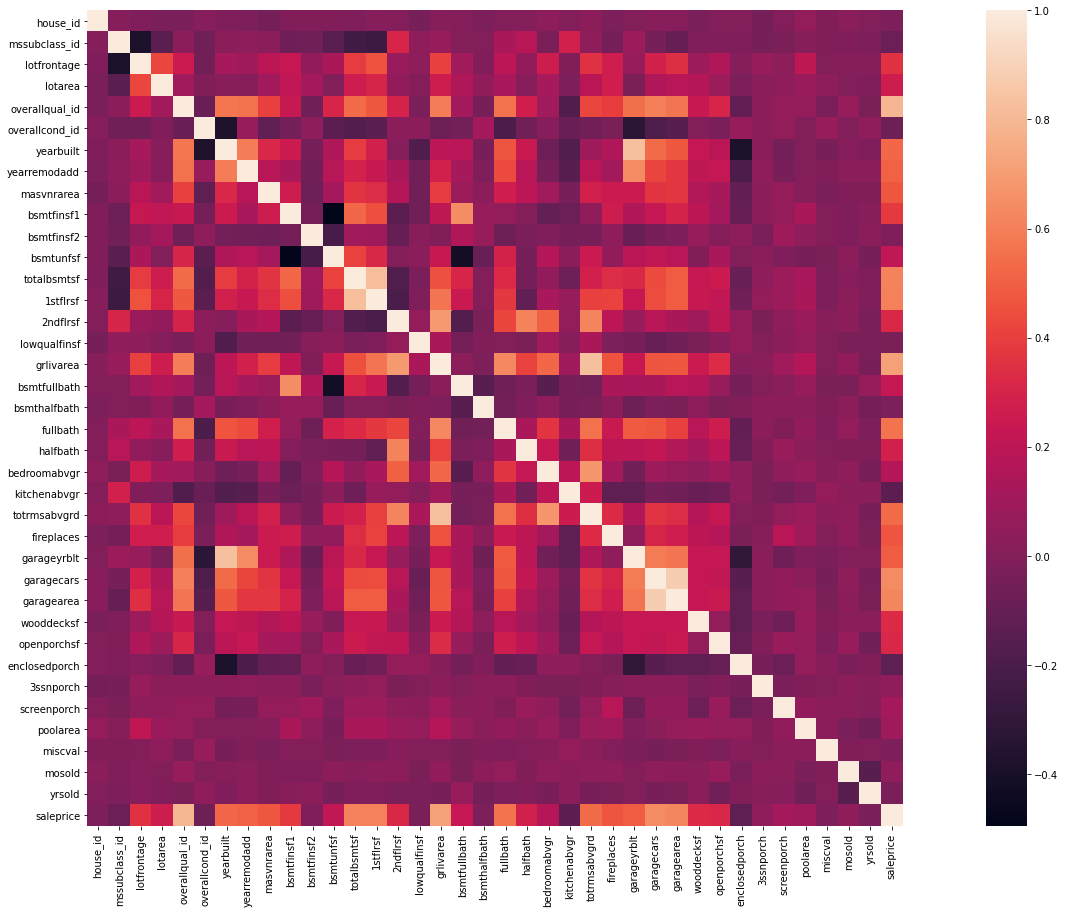

In [ ]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(30, 15))
sns.heatmap(corrmat, vmax=1, square=True)


In [ ]:
corrmat_2 = corrmat['saleprice'].sort_values(ascending=False).head(12).to_frame()

cm = sns.light_palette("purple", as_cmap=True)

corrmat_3 = corrmat_2.style.background_gradient(cmap=cm)
corrmat_3



,saleprice
saleprice,1.000000
overallqual_id,0.790982
grlivarea,0.708624
garagecars,0.640409
garagearea,0.623431
totalbsmtsf,0.613581
1stflrsf,0.605852
fullbath,0.560664
totrmsabvgrd,0.533723
yearbuilt,0.522897


# **Features Selected**
In total, we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5)

* overallqual_id
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* LotConfig
* Neighborhood
* BldgType
* Foundation



# **Step 3: Data cleaning:**

* remove null value or replace it with the mode of their respective columns
* remove duplicate if any
* check histogram and see if they are normally distributed in order to be used in linear regression model
* transform the skewed numeric features by taking log(feature + 1) -->make features more normally distributed
* create new feature to combine features that are in the same category
* transform categorical features using Encode Labels

*Note: some date cleaning has been done using SQL. (please refer to the SQL script. (ex. PoolQC NA have been replaced with 0 to mean No Pool) *italicized text*

In [ ]:
# combine train and test dataset
df_train.shape[0]
df_test.shape[0]
df = pd.concat((df_train, df_test), sort=False).reset_index(drop=True)
#Drop the house_id column since it doesn't help with prediction
df.drop("house_id", axis=1, inplace=True)
df


,mssubclass_id,mszoning_id,lotfrontage,lotarea,street_id,alley_id,lotshape_id,landcontour_id,utilities_id,lotconfig_id,landslope_id,neighborhood_id,condition1_id,condition2_id,bldgtype_id,housestyle_id,overallqual_id,overallcond_id,yearbuilt,yearremodadd,roofstyle_id,roofmatl_id,exterior1st_id,exterior2nd_id,masvnrtype_id,masvnrarea,exterqual_id,extercond_id,foundation_id,bsmtqual_id,bsmtcond_id,bsmtexposure_id,bsmtfintype1_id,bsmtfinsf1,bsmtfintype2_id,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating_id,heatingqc_id,...,electrical_id,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual_id,totrmsabvgrd,functional_id,fireplaces,fireplacequ_id,garagetype_id,garageyrblt,garagefinish_id,garagecars,garagearea,garagequal_id,garagecond_id,paveddrive_id,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc_id,fence_id,miscfeature_id,miscval,mosold,yrsold,saletype_id,salecondition_id,saleprice,data_type
0,90,RL,70.0,9842,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplx,1Story,4,5,1962,1962,Gable,CompShg,HdBoard,HdBoard,None,0,TA,TA,Slab,NA,NA,NA,NA,0,NA,0,0,0,GasA,TA,...,SBrkr,1224,0,0,1224,0,0,2,0,2,2,TA,6,Typ,0,NA,CarPort,1962.0,Unf,2.0,462.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,3,2007,WD,Normal,101800.0,Train
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500.0,Train
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500.0,Train
3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500.0,Train
4,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000.0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160,RM,21.0,1936,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CemntBd,None,0,TA,TA,CBlock,TA,TA,No,Unf,0,Unf,0,546,546,GasA,Gd,...,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,5,Typ,0,NA,NA,NaN,NA,0.0,0.0,NA,NA,Y,0,0,0,0,0,0,NA,NA,NA,0,6,2006,WD,Normal,NaN,Test
2915,160,RM,21.0,1894,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CemntBd,None,0,TA,TA,CBlock,TA,TA,No,Rec,252,Unf,0,294,546,GasA,TA,...,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,6,Typ,0,NA,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NA,NA,NA,0,4,2006,WD,Abnorml,NaN,Test
2916,20,RL,160.0,20000,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,CBlock,TA,TA,No,ALQ,1224,Unf,0,0,1224,GasA,Ex,...,SBrkr,1224,0,0,1224,1,0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NA,NA,NA,0,9,2006,WD,Abnorml,NaN,Test
2917,85,RL,62.0,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Nor

In [ ]:
df.dtypes

mssubclass_id         int32
mszoning_id          object
lotfrontage         float64
lotarea               int32
street_id            object
                     ...   
yrsold                int32
saletype_id          object
salecondition_id     object
saleprice           float64
data_type            object
Length: 81, dtype: object

In [ ]:
df['saleprice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

**check if target is normally distributed**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


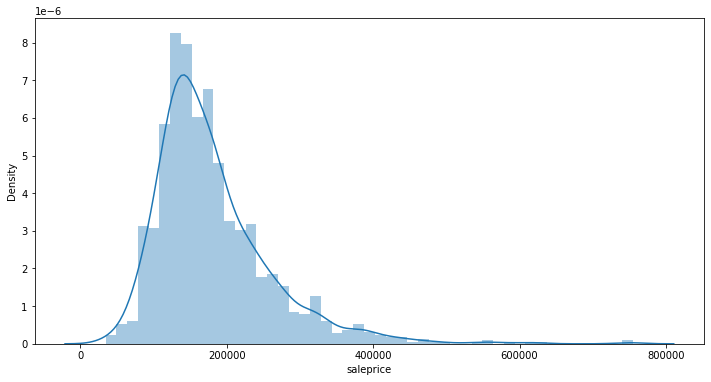

In [ ]:
# check if saleprice is normally distributed in order to be used in our Multiple linear regression model later
sns.distplot(df['saleprice']);
#we can see the saleprice is right skewed

# transform the the saleprice by taking log to make the data more normally distribute
df['saleprice'] = np.log1p(df['saleprice'])


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


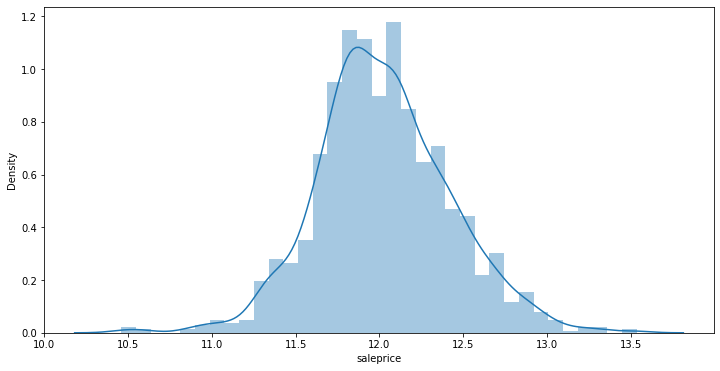

In [ ]:
#Check the new distribution to make sure its transformed
sns.distplot(df['saleprice']);

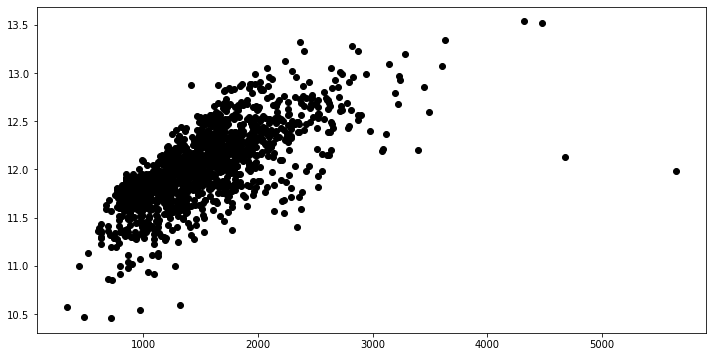

In [ ]:
#check the outlier from grlivarea
plt.scatter(y =df.saleprice,x = df.grlivarea,c = 'black')
plt.show()

In [ ]:
#check missing data ratio
missing_2 = (df.isnull().sum()/ len(df)) * 100
missing_2 = missing_2.drop(missing_2[missing_2 ==0].index).sort_values(ascending=False)[:30]
missing_2

saleprice         49.982871
lotfrontage       16.649538
garageyrblt        5.447071
mszoning_id        0.137033
functional_id      0.068517
utilities_id       0.068517
saletype_id        0.034258
garagearea         0.034258
garagecars         0.034258
kitchenqual_id     0.034258
electrical_id      0.034258
dtype: float64

In [ ]:
#Replace null values with o for garageyrblt, garagearea and garagecars with 0
for col in ('garageyrblt', 'garagearea', 'garagecars'):
  df[col] = df[col].fillna(0)

In [ ]:
df['mszoning_id'].value_counts()

RL    2265
RM     460
FV     139
RH      26
C       25
Name: mszoning_id, dtype: int64

In [ ]:
#replace null value in mmszoning_id with 'RL' which is the mode
df['mszoning_id'] = df['mszoning_id'].fillna(df['mszoning_id'].mode()[0])

In [ ]:
# null values saleprice are due to missing saleprice column in the test dataset
# we will replace missing values in lotfrontage with median lotfrontage of neighberhood 
df['lotfrontage'] = df.groupby('neighborhood_id')['lotfrontage'].transform(
      lambda x: x.fillna(x.median()))

In [ ]:
df["functional_id"].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: functional_id, dtype: int64

In [ ]:
df["functional_id"] = df["functional_id"].fillna(df["functional_id"].mode()[0])

df["utilities_id"].value_counts()
# drop the entire column since it only doesn't help with prediction
df = df.drop(['utilities_id'], axis=1)


In [ ]:
df["saletype_id"].value_counts()
df["saletype_id"] = df["saletype_id"].fillna(df["saletype_id"].mode()[0])

In [ ]:
df["kitchenqual_id"].value_counts()
df["kitchenqual_id"] = df["kitchenqual_id"].fillna(df["kitchenqual_id"].mode()[0])

In [ ]:
df["electrical_id"].value_counts()
df["electrical_id"] = df["electrical_id"].fillna(df["electrical_id"].mode()[0])

In [ ]:
df.duplicated().sum()

0

In [ ]:
#Convert categorical categories that shouldn't be categorical to numerical categories
#please refer to the description file for definition of each category
df['mssubclass_id'] = df['mssubclass_id'].apply(str)
df['yrsold'] = df['yrsold'].astype(str)
df['mosold'] = df['mosold'].astype(str)
df['overallcond_id'] = df['overallcond_id'].astype(str)
df['overallqual_id'] = df['overallqual_id'].astype(str)

In [ ]:
# combine an important feature
df['total_area'] = df['totalbsmtsf'] + df['1stflrsf'] + df['2ndflrsf'] + df['grlivarea'] + df['garagearea']

**check both numerical and categorical columns before further processing**

In [ ]:
numerical = df.select_dtypes(exclude='object')
numerical.columns

Index(['lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf',
       '2ndflrsf', 'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath',
       'fullbath', 'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'saleprice', 'total_area'],
      dtype='object')

In [ ]:
categorical = df.select_dtypes('object')
categorical.columns

Index(['mssubclass_id', 'mszoning_id', 'street_id', 'alley_id', 'lotshape_id',
       'landcontour_id', 'lotconfig_id', 'landslope_id', 'neighborhood_id',
       'condition1_id', 'condition2_id', 'bldgtype_id', 'housestyle_id',
       'overallqual_id', 'overallcond_id', 'roofstyle_id', 'roofmatl_id',
       'exterior1st_id', 'exterior2nd_id', 'masvnrtype_id', 'exterqual_id',
       'extercond_id', 'foundation_id', 'bsmtqual_id', 'bsmtcond_id',
       'bsmtexposure_id', 'bsmtfintype1_id', 'bsmtfintype2_id', 'heating_id',
       'heatingqc_id', 'centralair', 'electrical_id', 'kitchenqual_id',
       'functional_id', 'fireplacequ_id', 'garagetype_id', 'garagefinish_id',
       'garagequal_id', 'garagecond_id', 'paveddrive_id', 'poolqc_id',
       'fence_id', 'miscfeature_id', 'mosold', 'yrsold', 'saletype_id',
       'salecondition_id', 'data_type'],
      dtype='object')

**check if other numerical features are normally distributed**

In [ ]:
from scipy.stats import skew 
skewness = numerical.apply(lambda x: skew(x))
skewness.sort_values(ascending=False)


miscval          21.947195
poolarea         16.898328
lotarea          12.822431
lowqualfinsf     12.088761
3ssnporch        11.376065
kitchenabvgr      4.302254
bsmtfinsf2        4.146143
enclosedporch     4.003891
screenporch       3.946694
bsmthalfbath      3.931594
masvnrarea        2.614574
openporchsf       2.535114
wooddecksf        1.842433
lotfrontage       1.505704
1stflrsf          1.469604
bsmtfinsf1        1.425230
total_area        1.315599
grlivarea         1.269358
totalbsmtsf       1.156894
bsmtunfsf         0.919339
2ndflrsf          0.861675
totrmsabvgrd      0.758367
fireplaces        0.733495
halfbath          0.694566
bsmtfullbath      0.624832
bedroomabvgr      0.326324
garagearea        0.239257
fullbath          0.167606
garagecars       -0.219581
yearremodadd     -0.451020
yearbuilt        -0.599806
garageyrblt      -3.906205
saleprice              NaN
dtype: float64

In [ ]:
#normalize the data by taking log
skewness = np.log(skewness)
skewness.sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


miscval          3.088639
poolarea         2.827215
lotarea          2.551196
lowqualfinsf     2.492276
3ssnporch        2.431512
kitchenabvgr     1.459139
bsmtfinsf2       1.422179
enclosedporch    1.387267
screenporch      1.372878
bsmthalfbath     1.369045
masvnrarea       0.961101
openporchsf      0.930238
wooddecksf       0.611087
lotfrontage      0.409260
1stflrsf         0.384993
bsmtfinsf1       0.354333
total_area       0.274292
grlivarea        0.238511
totalbsmtsf      0.145739
bsmtunfsf       -0.084100
2ndflrsf        -0.148877
totrmsabvgrd    -0.276588
fireplaces      -0.309935
halfbath        -0.364467
bsmtfullbath    -0.470272
bedroomabvgr    -1.119863
garagearea      -1.430217
fullbath        -1.786141
yearbuilt             NaN
yearremodadd          NaN
garageyrblt           NaN
garagecars            NaN
saleprice             NaN
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


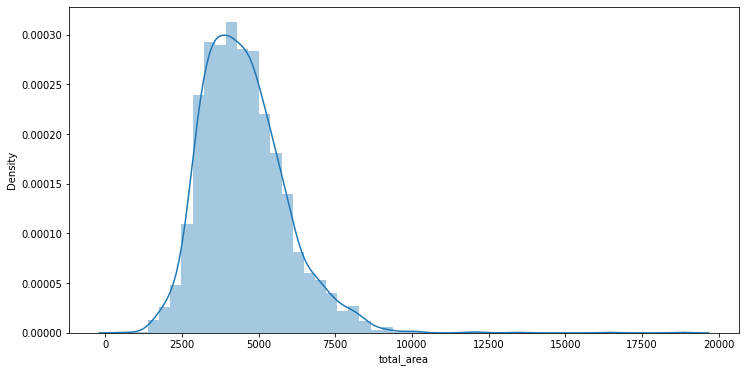

In [ ]:
#check the distribution of total_area
sns.distplot(df['total_area']);


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


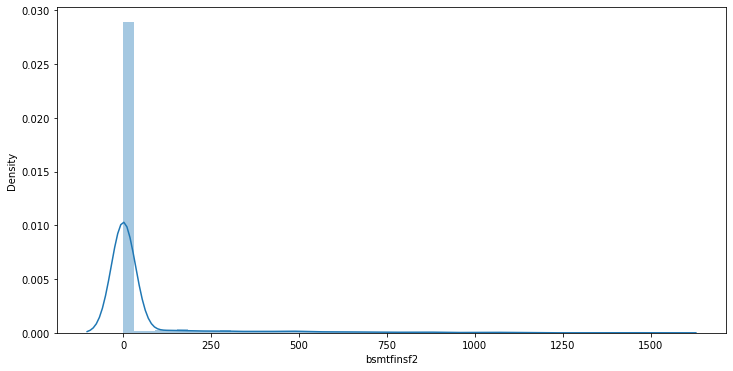

In [ ]:
#check the distribution of bsmtdinsf2
sns.distplot(df['bsmtfinsf2']);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


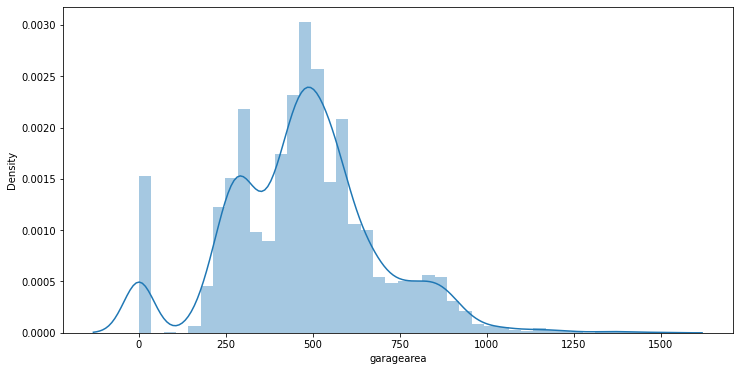

In [ ]:
#check the distribution of garagearea
sns.distplot(df['garagearea']);

**should we do box cox tranform to further normalize it? skewness > 0.75**

**Process categorical features using Label Encoding**


In [ ]:
#transform text into numerical data by applying LabelEncoder 
from sklearn.preprocessing import LabelEncoder
cols = ('mssubclass_id', 'mszoning_id', 'street_id', 'alley_id', 'lotshape_id',
       'landcontour_id', 'lotconfig_id', 'landslope_id', 'neighborhood_id',
       'condition1_id', 'condition2_id', 'bldgtype_id', 'housestyle_id',
       'overallqual_id', 'overallcond_id', 'roofstyle_id', 'roofmatl_id',
       'exterior1st_id', 'exterior2nd_id', 'masvnrtype_id', 'exterqual_id',
       'extercond_id', 'foundation_id', 'bsmtqual_id', 'bsmtcond_id',
       'bsmtexposure_id', 'bsmtfintype1_id', 'bsmtfintype2_id', 'heating_id',
       'heatingqc_id', 'centralair', 'electrical_id', 'kitchenqual_id',
       'functional_id', 'fireplacequ_id', 'garagetype_id', 'garagefinish_id',
       'garagequal_id', 'garagecond_id', 'paveddrive_id', 'poolqc_id',
       'fence_id', 'miscfeature_id', 'mosold', 'yrsold', 'saletype_id',
       'salecondition_id', 'data_type')

for col in cols:
  le = LabelEncoder()
  le.fit(list(df[col].values))
  df[col] = le.fit_transform(list(df[col].values))
df.shape  

(2919, 81)

In [ ]:
df.head()

,mssubclass_id,mszoning_id,lotfrontage,lotarea,street_id,alley_id,lotshape_id,landcontour_id,lotconfig_id,landslope_id,neighborhood_id,condition1_id,condition2_id,bldgtype_id,housestyle_id,overallqual_id,overallcond_id,yearbuilt,yearremodadd,roofstyle_id,roofmatl_id,exterior1st_id,exterior2nd_id,masvnrtype_id,masvnrarea,exterqual_id,extercond_id,foundation_id,bsmtqual_id,bsmtcond_id,bsmtexposure_id,bsmtfintype1_id,bsmtfinsf1,bsmtfintype2_id,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating_id,heatingqc_id,centralair,...,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual_id,totrmsabvgrd,functional_id,fireplaces,fireplacequ_id,garagetype_id,garageyrblt,garagefinish_id,garagecars,garagearea,garagequal_id,garagecond_id,paveddrive_id,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc_id,fence_id,miscfeature_id,miscval,mosold,yrsold,saletype_id,salecondition_id,saleprice,data_type,total_area
0,15,3,70.0,9842,1,1,3,3,2,0,12,2,2,2,2,4,4,1962,1962,1,1,6,6,2,0,3,4,3,3,2,3,4,0,4,0,0,0,1,4,1,...,1224,0,0,1224,0,0,2,0,2,2,3,6,6,0,3,4,1962.0,3,2.0,462.0,5,5,2,0,0,0,0,0,0,3,4,1,0,5,1,8,4,11.530775,1,2910.0
1,10,3,65.0,8450,1,1,3,3,4,0,5,2,2,0,5,7,4,2003,2003,1,1,13,14,1,196,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,...,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2.0,548.0,5,5,2,0,61,0,0,0,0,3,4,1,0,4,2,8,4,12.247699,1,4824.0
2,5,3,80.0,9600,1,1,3,3,2,0,24,1,2,0,2,6,7,1976,1976,1,1,8,8,2,0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,...,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2.0,460.0,5,5,2,298,0,0,0,0,0,3,4,1,0,7,1,8,4,12.109016,1,4246.0
3,10,3,68.0,11250,1,1,0,3,4,0,5,2,2,0,5,7,4,2001,2002,1,1,13,14,1,162,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,...,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2.0,608.0,5,5,2,0,42,0,0,0,0,3,4,1,0,11,2,8,4,12.317171,1,5100.0
4,11,3,60.0,9550,1,1,0,3,0,0,6,2,2,0,5,7,4,1915,1970,1,1,14,15,2,0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,...,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3.0,642.0,5,5,2,0,35,272,0,0,0,3,4,1,0,4,0,8,0,11.849405,1,4832.0


# **Step 4: Multiple Linear Regression Model: Predict house prices based on the selected features**
* Split the data into train and test (X:features, y=target)
* Scale the data
* Create an instance of the model with model = LinearRegression().
* Train the model with the dataset with model.fit(X,y)
* Create predictions with y_pred = model.predict(X)


In [ ]:
#Determine features and target
feature = df.drop(columns=['saleprice'])
target = df['saleprice']

print(feature)
print(target)

      mssubclass_id  mszoning_id  ...  data_type  total_area
0                15            3  ...          1      2910.0
1                10            3  ...          1      4824.0
2                 5            3  ...          1      4246.0
3                10            3  ...          1      5100.0
4                11            3  ...          1      4832.0
...             ...          ...  ...        ...         ...
2914              2            4  ...          0      2730.0
2915              2            4  ...          0      3016.0
2916              5            3  ...          0      4248.0
2917             14            3  ...          0      2852.0
2918             10            3  ...          0      5646.0

[2919 rows x 80 columns]
0       11.530775
1       12.247699
2       12.109016
3       12.317171
4       11.849405
          ...    
2914          NaN
2915          NaN
2916          NaN
2917          NaN
2918          NaN
Name: saleprice, Length: 2919, dtype: float6

# **Features Selected**
In total, we selected 15 features.

***NUmerical Category:***
Based on heatmap, pick the top 11 features that are most correlated to sales price(vmax>0.5). We also added another additional features: total_area

* overallqual_id
* grlivarea	
* garagecars
* garagearea
* totalbsmtsf	
* 1stflrsf
* fullbath	
* totrmsabvgrd
* yearbuilt	
* yearremodadd
* ADDED total_area

***Categorical Category:***
Categorical object can not be compared using heatmap so we selected a few more features based on commonsense
* lotconfig_id
* neighborhood_id
* bldgtype_id
* foundation_id


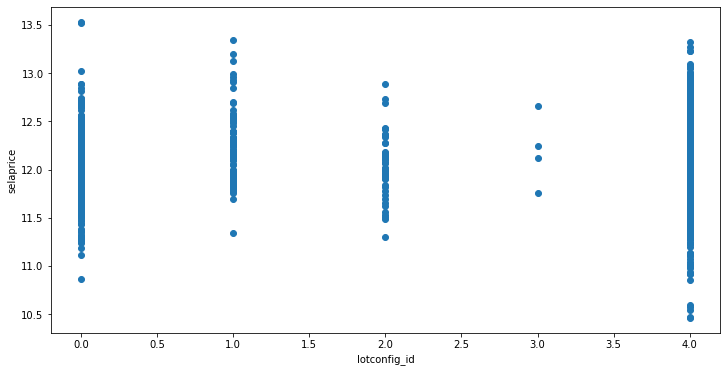

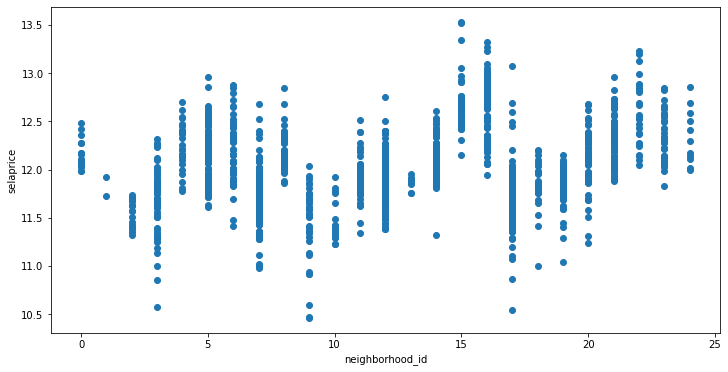

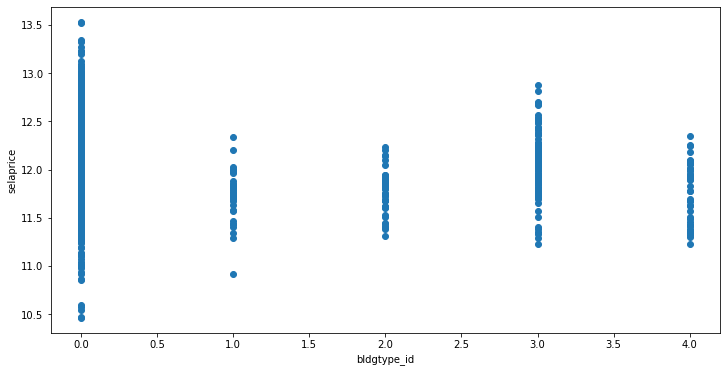

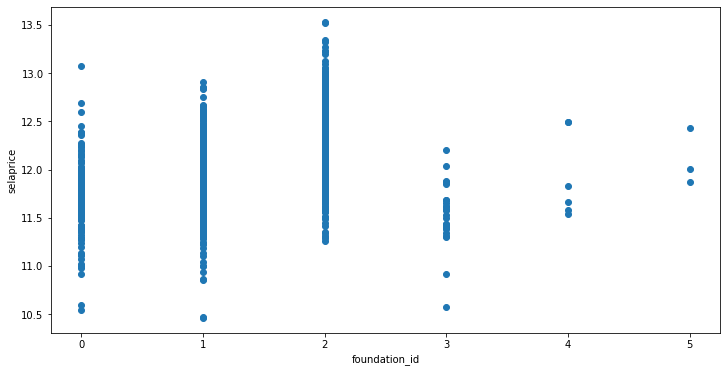

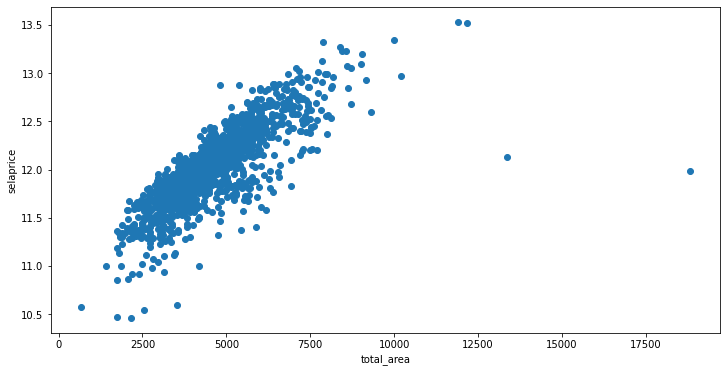

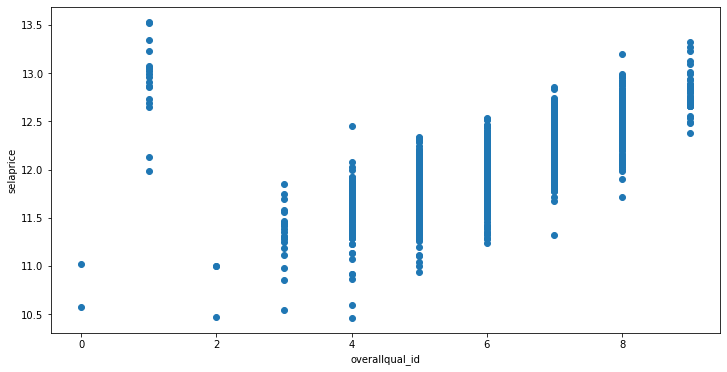

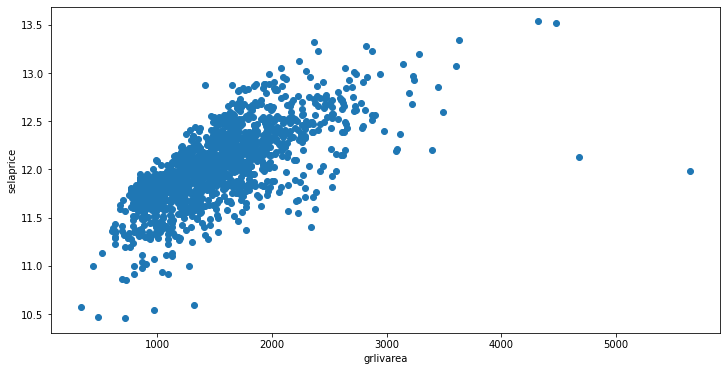

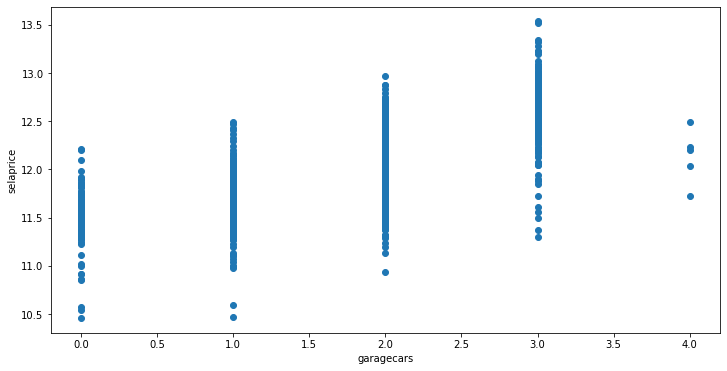

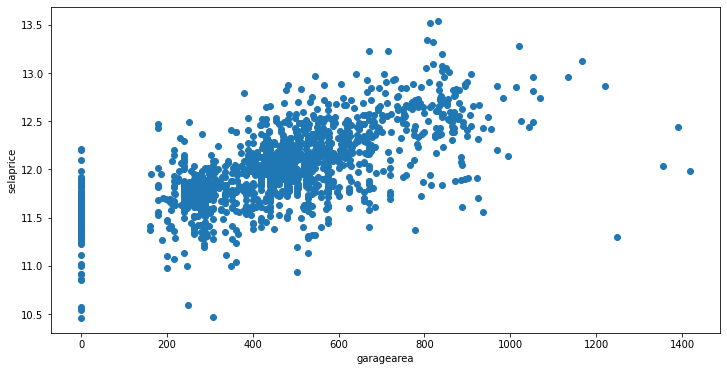

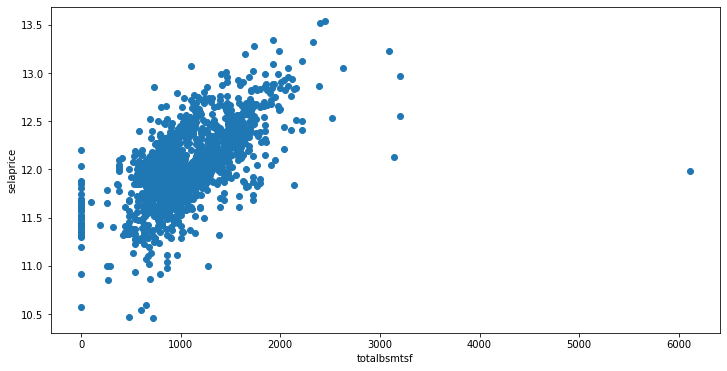

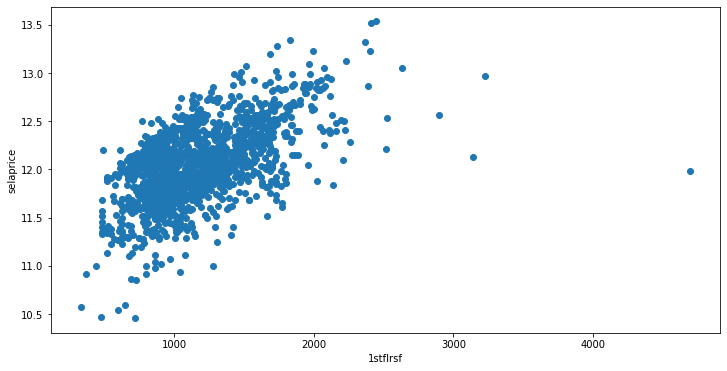

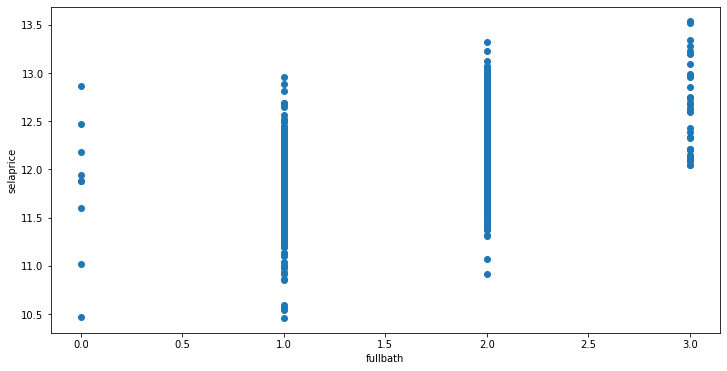

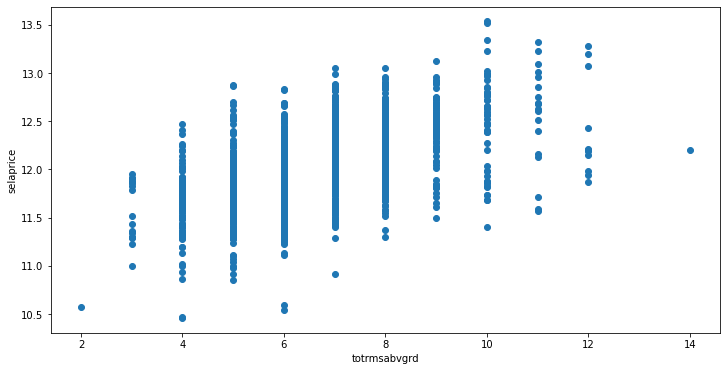

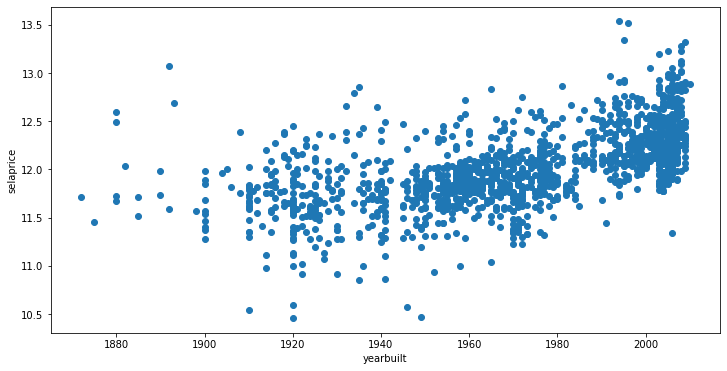

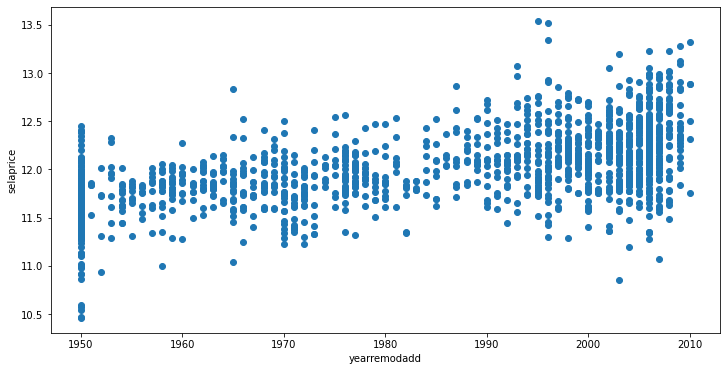

In [ ]:
x_features = ["lotconfig_id", "neighborhood_id", "bldgtype_id", "foundation_id","total_area","overallqual_id","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]
for x in x_features:

  plt.scatter(df[x], df['saleprice'])
  plt.xlabel(x)
  plt.ylabel('selaprice')
  plt.show()

In [ ]:
len(x_features)
df["data_type"].value_counts

<bound method IndexOpsMixin.value_counts of 0       1
1       1
2       1
3       1
4       1
       ..
2914    0
2915    0
2916    0
2917    0
2918    0
Name: data_type, Length: 2919, dtype: int64>

**Do we need datatype column?**

In [ ]:
#put our selected features into cols
cols = ["lotconfig_id", "neighborhood_id", "bldgtype_id", "foundation_id","total_area","overallqual_id","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

#cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
#set out input/feature(x) and output/target(y)
train = df[:1460]
test = df[1460:]
train.shape
y = train['saleprice'].values
X = train[cols].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(train,y,test_size = 0.3,random_state= 0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1022, 81), (438, 81), (1022,), (438,))

In [ ]:
clfs = {
        'svm':svm.SVR(), 
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
        'BayesianRidge':linear_model.BayesianRidge()
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)
        y_pred = clfs[clf].predict(X_test)
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) )
    except Exception as e:
        print(clf + " Error:")
        print(str(e))

print(y_pred)
model = LinearRegression()
# We will be using the columns from the dataset excluding Sales Price to output the SalesPrice
model.fit(X, y)
y_pred = model.predict(X)

print(y_pred.shape)

svm cost:0.009131147251064039
RandomForestRegressor cost:-0.0007484475216440594
BayesianRidge cost:4.4865180161564986e-08
[11.36209352 11.65268655 11.98916109 12.93677895 12.76569764 12.01369743
 12.55292251 12.52454035 12.88026559 12.33656861 12.24962096 12.35451239
 12.32386718 11.71993037 11.35041404 11.97035952 12.15479333 11.35042414
 10.59670301 12.8320083  12.46843723 12.10626135 11.64834598 11.89818125
 12.36790793 12.75996847 12.08672633 11.95119265 11.81304582 11.8422112
 12.17818894 12.04941841 12.54255529 11.84941368 11.60368169 11.58989611
 12.01672603 12.5672526  11.73604984 11.57120787 12.12269345 12.86099224
 12.41104504 12.10626282 11.90496932 11.26447989 11.77143248 11.45636282
 11.71913018 11.65267066 11.99843435 11.89818328 12.03112661 11.5758789
 11.81303983 11.71993663 12.15479751 11.44569428 11.60822648 11.51291943
 11.2318927  11.81302501 11.99380342 12.1034718  11.76761119 11.96082953
 12.07825605 11.69523983 11.84223527 11.4403652  12.08954804 11.77454068
 12.


# **Step 5: Statistical Summary**
* check the accuracy of our model

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))
print(model.coef_)
print(model.intercept_)

ValueError: ignored

In [ ]:
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor

#put our selected features into cols
cols = ["lotconfig_id", "neighborhood_id", "bldgtype_id", "foundation_id","total_area","overallqual_id","grlivarea", "garagecars","garagearea","totalbsmtsf","1stflrsf","fullbath","totrmsabvgrd", "yearbuilt","yearremodadd"]

#cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']
#set out input/feature(x) and output/target(y)
x = train[cols].values
y = train['saleprice'].values
#scale the data
x_scaled = preprocessing.StandardScaler().fit_transform(x.reshape(-1,1))
y_scaled = preprocessing.StandardScaler().fit_transform(y.reshape(-1,1))
X_train,X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.33, random_state=42)

clfs = {
        'svm':svm.SVR(), 
        'RandomForestRegressor':RandomForestRegressor(n_estimators=400),
        'BayesianRidge':linear_model.BayesianRidge()
       }
for clf in clfs:
    try:
        clfs[clf].fit(X_train, y_train)
        y_pred = clfs[clf].predict(X_test)
        print(clf + " cost:" + str(np.sum(y_pred-y_test)/len(y_pred)) )
    except Exception as e:
        print(clf + " Error:")
        print(str(e))



ValueError: ignored